In [50]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
SAVE_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase/results'
import pandas as pd
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

In [60]:
def load_results(DATASET):
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_scores_full.pkl', 'rb') as f :
        results = pickle.load(f)
    return results
    
def bootstrap_ci(data, alpha=0.95):
    estimates = {}
    for c in data:
        estimates[c]={}
        for arch in data[c]:
            res = data[c][arch]
            median = np.mean(res)
            bs_reps = bootstrap(np.array(res).reshape(1,-1), statistic=np.mean, n_resamples=1000)
            ci = bs_reps.confidence_interval[0:2]
            estimates[c][arch] = (median, ci[0], ci[1])
    return estimates

def bootstrap_samples(data, n_iterations):
    n = len(data)
    indices = np.random.randint(0, n, (n_iterations, n))
    return data[indices]

def get_difference_estimates(results):
    results_diff = {}
    n_iterations = 1000
    for cost in results:
        results_diff[cost] = {}
        for architecture in list(results[cost].keys())[1:]:
            single = np.array(results[cost]['single'])
            other = np.array(results[cost][architecture])
            bs_single_samples = bootstrap_samples(single, n_iterations)
            bs_other_samples = bootstrap_samples(other, n_iterations)
            bs_single_means = np.median(bs_single_samples, axis=1)
            bs_other_means = np.median(bs_other_samples, axis=1)
            bs_diff = bs_other_means - bs_single_means 
            mean_single = np.median(single)
            median_diff = 100 * np.percentile(bs_diff, 50) / mean_single
            lower_ci_diff = 100 * np.percentile(bs_diff, 5) / mean_single
            upper_ci_diff = 100 * np.percentile(bs_diff, 95) / mean_single
            results_diff[cost][architecture] = (np.round(median_diff, 3), np.round(lower_ci_diff, 3), np.round(upper_ci_diff, 3))
    return pd.DataFrame.from_dict(results_diff, orient='index')

def print_med_results(DATASET):
    results = load_results(DATASET)
    for arch in ['single', 'joint', 'federated', 'pfedme', 'ditto']:
        print(arch)
        for c in results:
            print(np.median(results[c][arch]))
        print('----')

def grapher(results, DATASET, metric, costs, save):
    results_long = results.reset_index().rename(columns={'index': 'cost'}).melt(id_vars=['cost'], var_name='architecture')
    results_long[['median_diff', 'lower_ci_diff', 'upper_ci_diff']] = pd.DataFrame(results_long['value'].tolist(), index=results_long.index)
    results_long.drop(columns=['value'], inplace=True)
    results_long
    plt.figure()
    for architecture in results_long['architecture'].unique():
        subset = results_long[results_long['architecture'] == architecture]
        sns.lineplot(x='cost', y='median_diff', marker = 'o', data=subset, label=architecture.capitalize())
        if DATASET not in ['IXITiny', 'ISIC']:
            plt.fill_between(x=subset['cost'], y1=subset['lower_ci_diff'], y2=subset['upper_ci_diff'], alpha=0.2)
    plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
    plt.xlabel('Dataset Cost', fontsize = 14)
    plt.ylabel(f'% Change in {metric}', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/{DATASET}/{DATASET}_scores_change.pdf', bbox_inches='tight')
    plt.show()

def load_results_grad(DATASET):
    with open(f'{ROOT_DIR}/results/{DATASET}/{DATASET}_gradient_diversities_full.pkl', 'rb') as f :
        results = pickle.load(f)
    return results

def grapher_grad(DATASET, save):
    results = load_results_grad(DATASET)
    for cost in results:
        values = pd.Series(results[cost]['cosine'])
        ema_result = values.ewm(span=50, adjust=False).mean()
        sns.lineplot(ema_result, label = cost)
    plt.xlabel('Epoch', fontsize = 14)
    plt.ylabel(f'Gradient diversity', fontsize = 14)
    plt.legend(title = 'Cost')
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{SAVE_DIR}/{DATASET}/{DATASET}_gradient_diversity.pdf', bbox_inches='tight')
    plt.show()

def process_results(DATASET):
    dataset_dict = {'Synthetic':['F1', '0.03-0.6'],
                'Credit': ['F1', '0.12-0.40'],
                'Weather': ['R2', '0.11-0.48'],
                'EMNIST': ['Accuracy', '0.11-0.39'],
                'CIFAR': ['Accuracy', '0.08-0.38'],
                'ISIC': ['Balanced Accuracy', '0.06-0.30'],
                'IXITiny': ['DICE', '0.08-0.30']}

    results = load_results(DATASET)
    results_estimates = bootstrap_ci(results, alpha=0.95)
    results_diff_estimates = get_difference_estimates(results)
    metric, costs = dataset_dict[DATASET]
    save = True
    grapher(results_diff_estimates, DATASET, metric, costs, save)
    grapher_grad(DATASET, save)
    return 

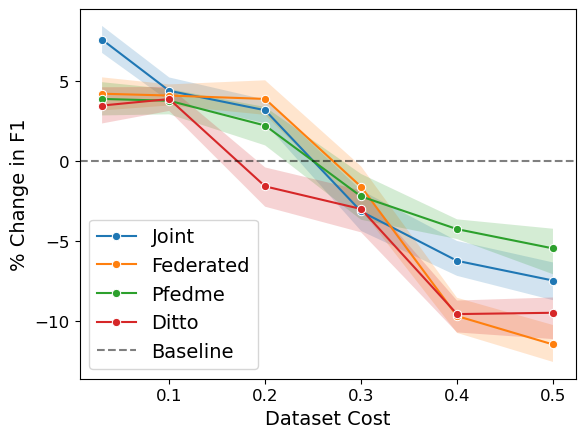

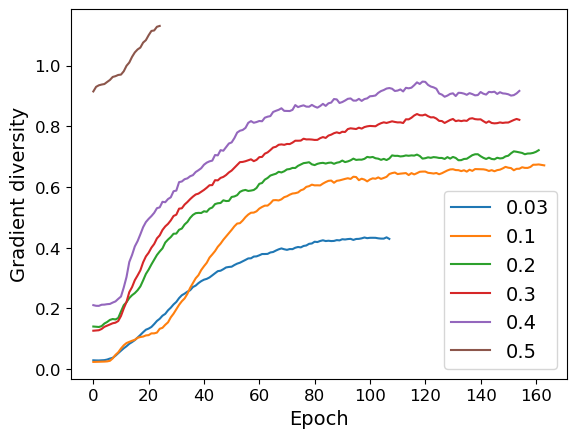

In [70]:
DATASET = 'Synthetic'
process_results(DATASET)

In [27]:
print_med_results(DATASET)

single
0.6518507555950208
0.6388308977035491
0.6270403365638095
0.656778063102699
0.6841575770411945
0.6825741890959283
----
joint
0.7013086913086913
0.6666666666666666
0.6466868672293966
0.6359800130656639
0.6414718484552357
0.6321138022046267
----
federated
0.6793682795698923
0.6653060714479093
0.6511856564488143
0.6466873373962009
0.6180850279247205
0.6039197207678884
----
pfedme
0.6772817819630569
0.6628351224883017
0.6408206781776575
0.6422508100478008
0.6551993114207326
0.6457191046232141
----
ditto
0.6740670033255327
0.6633737641744843
0.6164392852484675
0.6371998371998373
0.6187607573149743
0.6185832872163807
----


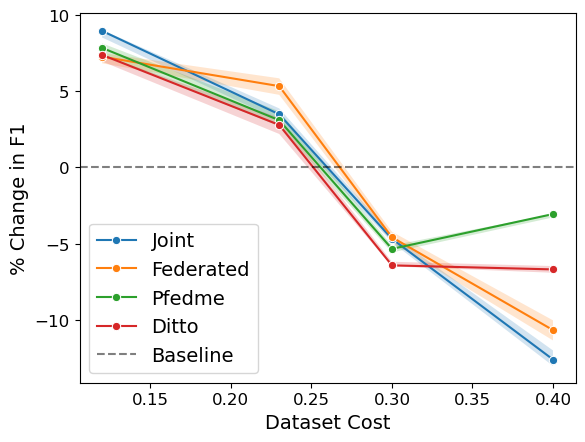

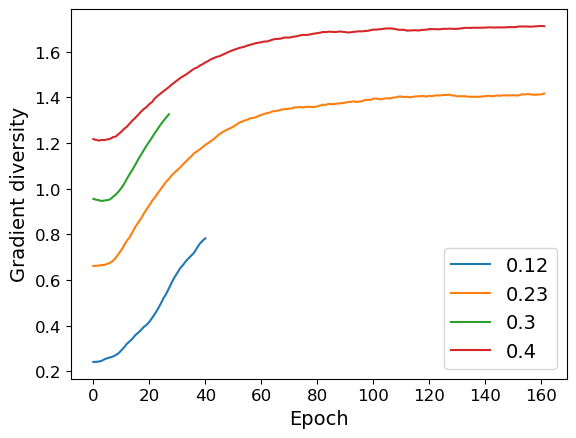

In [71]:
DATASET = 'Credit'
process_results(DATASET)

In [29]:
print_med_results(DATASET)

single
0.8754208754208754
0.8519331454931325
0.9442508710801394
0.96229802513465
----
joint
0.9538461538461538
0.8809282700421941
0.8998178506375228
0.8410838864965493
----
federated
0.9401197604790419
0.8967032967032967
0.900999900999901
0.8593681917211329
----
pfedme
0.9440993788819875
0.8791940262652146
0.8937728937728937
0.9328358208955224
----
ditto
0.9400630914826499
0.874439461883408
0.8835489833641405
0.8978805394990367
----


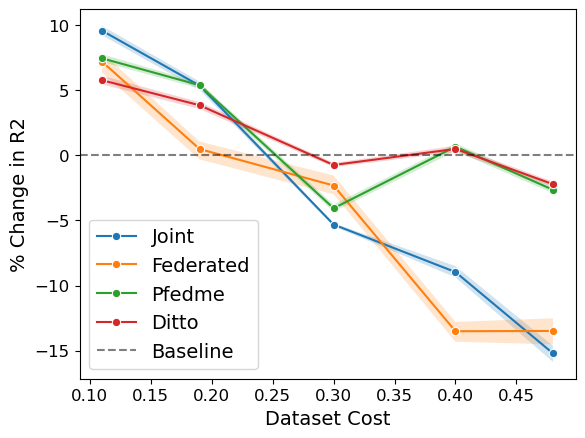

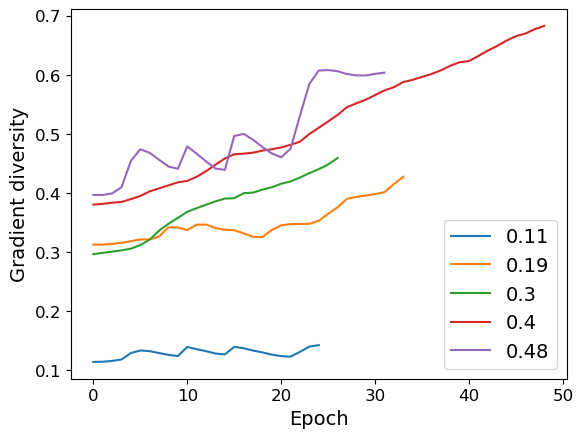

In [72]:
DATASET = 'Weather'
process_results(DATASET)

In [31]:
print_med_results(DATASET)

single
0.854239382442066
0.8826015506005022
0.8966864076838728
0.8943787325705969
0.9086801456354638
----
joint
0.9362770690050146
0.929781046134423
0.8491276312916893
0.8141084113645116
0.7701722431774987
----
federated
0.9158722231150623
0.8870048292473456
0.8757771592513595
0.773531227466213
0.7860377534672041
----
pfedme
0.9180776045971423
0.9302815785004004
0.8603369958114757
0.9004919402043893
0.8846411252306381
----
ditto
0.9036269365549945
0.9166344927028992
0.89006644304196
0.8991025835778769
0.8885523868139739
----


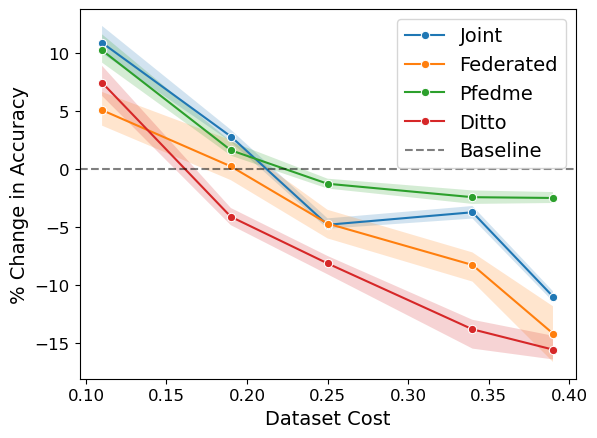

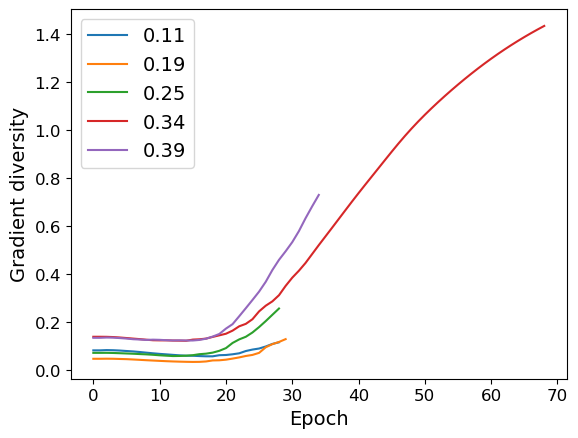

In [73]:
DATASET = 'EMNIST'
process_results(DATASET)

In [33]:
print_med_results(DATASET)

single
0.8706666666666667
0.8207142857142857
0.8046296296296296
0.831
0.8872
----
joint
0.9650000000000001
0.8435714285714286
0.7659259259259259
0.7995
0.7902666666666667
----
federated
0.9123333333333333
0.8209523809523811
0.7672527770531768
0.7631666666666667
0.7630666666666666
----
pfedme
0.9586666666666667
0.8330952380952381
0.7946296296296296
0.8111666666666667
0.8650666666666667
----
ditto
0.9343333333333333
0.7864285714285715
0.7388888888888889
0.7166666666666667
0.7492000000000001
----


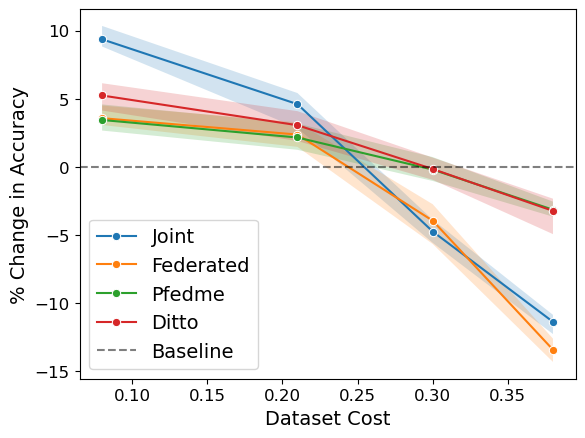

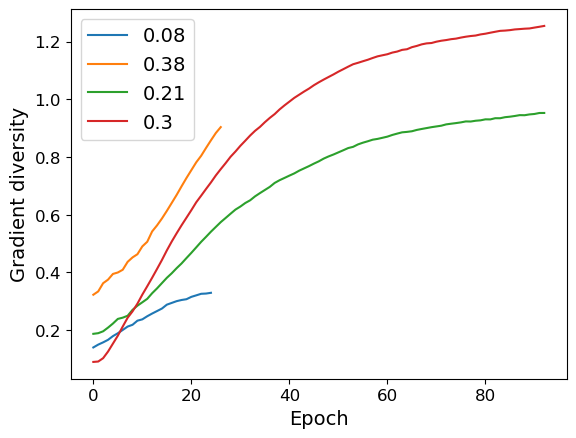

In [78]:
DATASET = 'CIFAR'
process_results(DATASET)

In [35]:
print_med_results(DATASET)

single
0.8043333333333333
0.7933333333333333
0.8013333333333333
0.7776666666666667
----
joint
0.9026666666666667
0.8320000000000001
0.7643333333333334
0.6963333333333332
----
federated
0.8536666666666666
0.8029999999999999
0.7696666666666667
0.676
----
pfedme
0.8706666666666667
0.7993333333333333
0.7976666666666667
0.752
----
ditto
0.871
0.8086666666666666
0.8026666666666666
0.7376666666666667
----


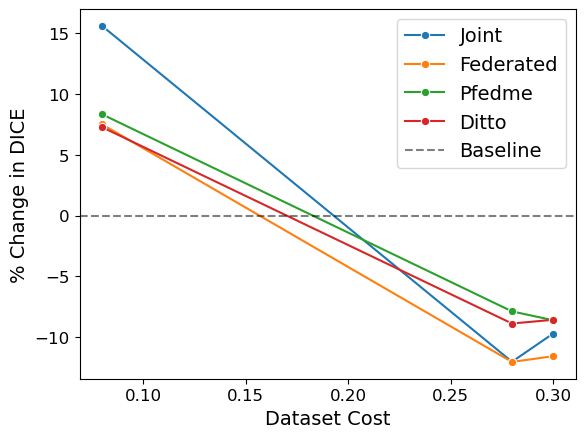

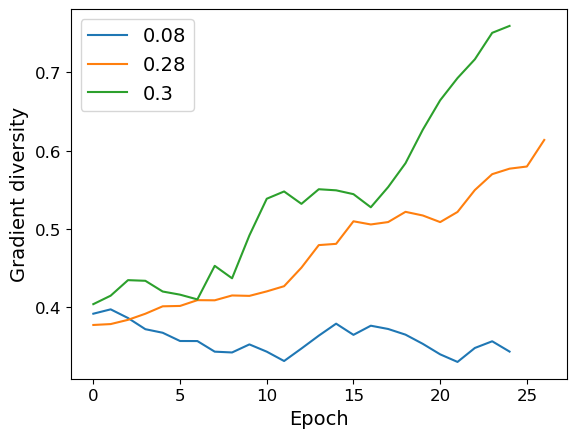

In [75]:
DATASET = 'IXITiny'
process_results(DATASET)

In [40]:
print_med_results(DATASET)

single
0.3682343661785126
0.4288037419319153
0.4207008719444275
----
joint
0.4256543815135956
0.3772802364826202
0.37985945284366607
----
federated
0.3958594271540642
0.377212769985199
0.3720516860485077
----
pfedme
0.39889350354671477
0.3950303244590759
0.3845212411880493
----
ditto
0.3950003907084465
0.3907560532391071
0.3846449017524719
----


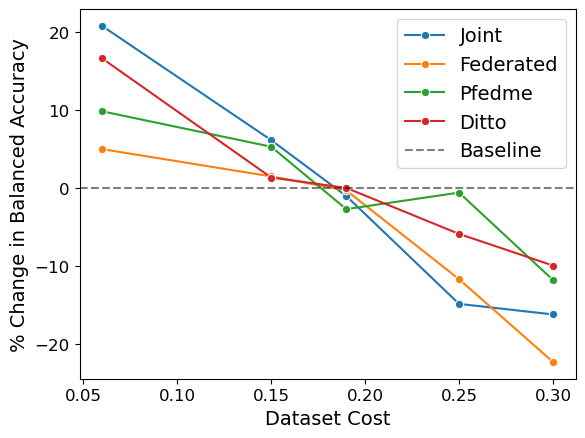

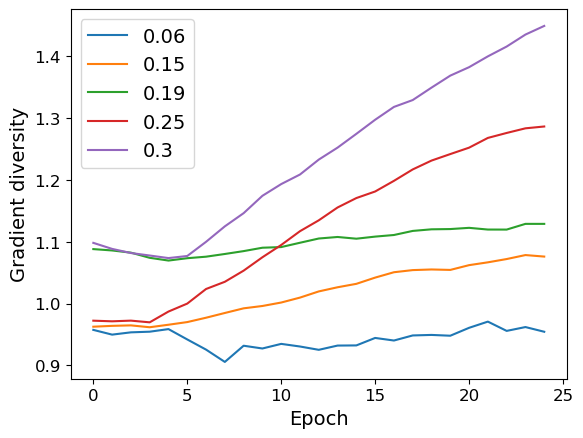

In [76]:
DATASET = 'ISIC'
process_results(DATASET)

In [45]:
print_med_results(DATASET)

single
0.4324131518423357
0.5051594569556621
0.5191107964492372
0.5176522674160814
0.4720254010695187
----
joint
0.5220940010555761
0.5360059544562561
0.5135863792183258
0.44061548658285715
0.3953877005347593
----
federated
0.4538231917336395
0.5125
0.5173709547042351
0.4569855990838843
0.36666666666666664
----
pfedme
0.474791541289239
0.5317245799347261
0.5048695482563377
0.5144353833421792
0.41622103386809267
----
ditto
0.50412098857002
0.5117951262509058
0.5190020030779002
0.48703416039872055
0.42497103386809265
----
